### Split the data on the disk into a train, validation and test set

1. Create for each tile on folder which contains the folder from every season for this tile
2. Random sample tiles for the train, validation and test set
3. Copy the tiles from the disk to the train, validation and test folder

In [2]:
from pathlib import Path
import rasterio
import re
import os
import random
import shutil
import torch
from tqdm import tqdm
from datetime import datetime, date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
IDENTIFIER_REGEX = re.compile(
    r"""(?P<mission>S2[A-B])_MSI
        (?P<product_level>L[1-2][A-C])_
        (?P<sensing_time>\d{8}T\d{6})_
        (?P<processing_baseline>N\d{4})_
        (?P<relative_orbit>R\d{3})_T
        (?P<utm_code>\d{2})
        (?P<latitude_band>\w{1})
        (?P<square>\w{2})_
        (?P<year>\d{4})
        (?P<month>\d{2})
        (?P<day>\d{2})T
        (?P<product_time>\d{6})""",
    re.VERBOSE,
)

In [10]:
def get_tile_and_date(identifier: str):
    regex_match = re.search(IDENTIFIER_REGEX, identifier)

    if not regex_match:
        return None, None

    utm_code = regex_match.group("utm_code")
    latitude_band = regex_match.group("latitude_band")
    square = regex_match.group("square")
    year = regex_match.group("year")
    # remove leading zeros
    month = str(int(regex_match.group("month")))
    day = str(int(regex_match.group("day")))

    tile = f"{utm_code}{latitude_band}{square}"
    tile_date = f"{year}-{month}-{day}"

    return tile, tile_date

In [47]:
images_prepro_path = Path(r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\images_only_AOI_test_color_corr_cleaned')
masks_prepro_path = Path(r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\masks_only_AOI_test_color_corr_cleaned')

In [8]:
seasons_dict = {"winter":{'start_date':date(2018, 1, 1), 'end_date':date(2018, 3, 31)},
                "spring":{'start_date':date(2018, 4, 1), 'end_date':date(2018, 6, 30)},
                "summer":{'start_date':date(2018, 7, 1), 'end_date':date(2018, 9, 30)},
                "autumn":{'start_date':date(2018, 10, 1), 'end_date':date(2018, 11, 30)}}

### Count number of tiles from each season

In [13]:
# count number of tiles from each season
directory = Path(r"C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\training_data_raw")
tiles_per_season = {"winter": 0, "spring": 0, "summer": 0, "autumn": 0}
# Iterate over the files in the directory
for filename in os.listdir(directory):
    # Extract the tile name and date from the filename
    tile, tile_date = get_tile_and_date(filename)
    if tile is None or tile_date is None:
        continue

    # Convert the date to a datetime object
    tile_datetime = datetime.strptime(tile_date, "%Y-%m-%d").date()

    # Determine the season based on the date
    season = None
    for season_name, season_dates in seasons_dict.items():
        if season_dates['start_date'] <= tile_datetime <= season_dates['end_date']:
            season = season_name
            break

    # If the season was determined, increment the count for that season
    if season is not None:
        tiles_per_season[season] += 1

# Display the number of tiles for each season
total_tiles = sum(tiles_per_season.values())
for season, count in tiles_per_season.items():
    print(f"{season}: {count} tiles")
print(f"Total: {total_tiles} tiles")

winter: 2 tiles
spring: 60 tiles
summer: 77 tiles
autumn: 53 tiles
Total: 192 tiles


## Create a list of all tiles which are available on the disk

In [ ]:
def index_to_filename(image_dir: Path, set_list: list) -> list:
    set_filenames = []
    for file_path in image_dir.glob("*.pt"):
        tile, number, date = file_path.stem.split("_")
        if (tile, number) in set_list:
            set_filenames.append(str(file_path))  # .name
    return set_filenames

In [52]:
# create a list of all tiles
tile_list = []
for file_path in images_prepro_path.glob("*.pt"):
    filename = file_path.stem
    tile, number, date = filename.split("_")
    tile_list.append(tile)

# set is used to get unique values of tiles
tiles_unique = list(set(tile_list))

In [ ]:
# select random tiles for train, val and test
random.seed(42)
random.shuffle(tiles_unique)

num_total = len(tiles_unique)
num_train = int(num_total * 0.7)
num_val = int(num_total * 0.1)

In [54]:
# create train, val and test list
train_list = tiles_unique[:num_train]
val_list = tiles_unique[num_train : num_train + num_val]
test_list = tiles_unique[num_train + num_val :]

In [56]:
# create a directory for each set
train_dir = Path(r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\data_splitted')
for set_name in ["train", "val", "test"]:
    os.makedirs(train_dir / set_name, exist_ok=True)
    os.makedirs(train_dir / set_name / "images", exist_ok=True)
    os.makedirs(train_dir / set_name / "masks", exist_ok=True)

In [69]:
for file in images_prepro_path.glob("*.pt"):
    file_stammed = file.stem
    filename = file.name
    tile, _, _ = file_stammed.split("_")
    if tile in train_list:
        shutil.copyfile(images_prepro_path / filename, train_dir / "train" / "images" / filename)
        shutil.copyfile(masks_prepro_path / filename, train_dir / "train" / "masks" / filename)
    elif tile in val_list:
        shutil.copyfile(images_prepro_path / filename, train_dir / "val" / "images" / filename)
        shutil.copyfile(masks_prepro_path / filename, train_dir / "val" / "masks" / filename)
    elif tile in test_list:
        shutil.copyfile(images_prepro_path / filename, train_dir / "test" / "images" / filename)
        shutil.copyfile(masks_prepro_path / filename, train_dir / "test" / "masks" / filename)
    else:
        print("Error: Tile not in any set!")

In [73]:
# check if all files are copied
print("Number of files in each set:")
print(f'Train images: {len(list(train_dir.glob("train/images/*.pt")))}')
print(f'Train masks: {len(list(train_dir.glob("train/masks/*.pt")))}')
print(f'Val images: {len(list(train_dir.glob("val/images/*.pt")))}')
print(f'Val masks: {len(list(train_dir.glob("val/masks/*.pt")))}')
print(f'Test images: {len(list(train_dir.glob("test/images/*.pt")))}')
print(f'Test masks: {len(list(train_dir.glob("test/masks/*.pt")))}')

Number of files in each set:
Train images: 3832
Train masks: 3832
Val images: 489
Val masks: 489
Test images: 342
Test masks: 342


In [ ]:
print("Sum of all files:")
print(f'Images: {len(list(train_dir.glob("**/*.pt")))}')

### Same as before, but now with the undersampled data

### But First EDA about the data

In [230]:
# create histogram of masks sizes in dataset
mask_size_list = []
file_paths_list = []
masks_prepro_path = Path(r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\masks_undersampling')
for file_path in masks_prepro_path.glob('*.tif'):
    mask = rasterio.open(file_path).read()
    if mask.sum() > 0:
        mask_size_list.append(mask.sum())
        file_paths_list.append(file_path)

In [231]:
df = pd.DataFrame({'mask_size':mask_size_list, 'file_path':file_paths_list})

In [30]:
mean_mask_size = np.mean(mask_size_list)
median_mask_size = np.median(mask_size_list)

In [31]:
print(f"Max mask size: {max(mask_size_list)}")
print(f"Min mask size: {min(mask_size_list)}")
print(f"Mean mask size: {round(mean_mask_size, 2)}")
print(f"Median mask size: {median_mask_size}")

Max mask size: 20738
Min mask size: 2
Mean mask size: 811.32
Median mask size: 461.0


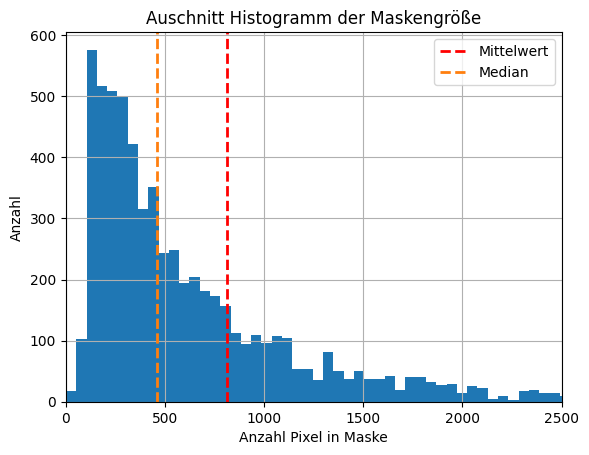

In [32]:
plt.hist(mask_size_list, bins=400, )
plt.grid(True)
plt.xlim(0, 2500)
plt.xlabel('Anzahl Pixel in Maske')
plt.ylabel('Anzahl')
plt.title('Auschnitt Histogramm der Maskengröße')
plt.axvline(mean_mask_size, color='r', linestyle='dashed', linewidth=2)
plt.axvline(median_mask_size, color='tab:orange', linestyle='dashed', linewidth=2)
plt.legend(['Mittelwert', 'Median'])
plt.show()

In [234]:
df.sort_values(by=['mask_size'], ascending=True, inplace=True)

In [235]:
df.head()

,mask_size,file_path
5978,2,C:\Users\Fabian\Documents\Github_Masterthesis\...
5979,2,C:\Users\Fabian\Documents\Github_Masterthesis\...
2751,3,C:\Users\Fabian\Documents\Github_Masterthesis\...
3154,6,C:\Users\Fabian\Documents\Github_Masterthesis\...
5849,11,C:\Users\Fabian\Documents\Github_Masterthesis\...


Mask size: 88


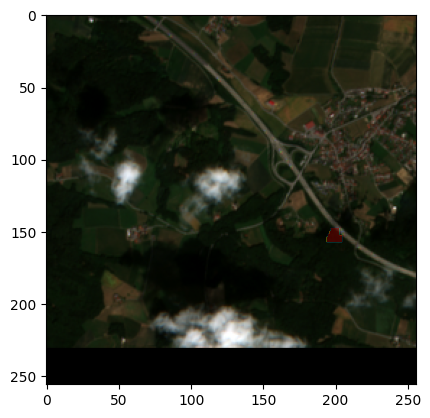

In [276]:
path_to_images = Path(r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\images_undersampling')
file_path = df.iloc[45, 1]
image = rasterio.open(path_to_images/file_path.name).read()[1:4, :, :].transpose(1, 2, 0)
mask = rasterio.open(file_path).read()
plt.imshow(image);
plt.imshow(mask[0, :, :], alpha=0.5*(mask[0, :, :] > 0), cmap='jet');
print(f"Mask size: {mask.sum()}")
# plt.ylim(0, 100)
# plt.xlim(50, 150)

(100.0, 200.0)

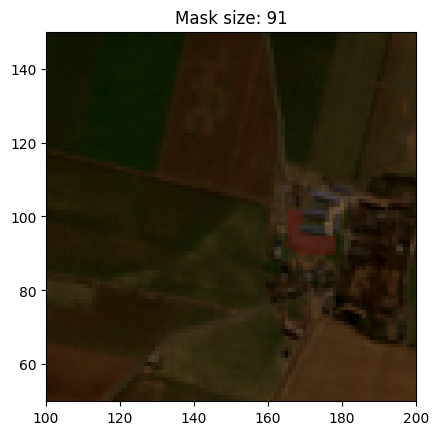

In [351]:
file_path_small_mask = df.iloc[54, 1]
image_small_mask = rasterio.open(path_to_images/file_path_small_mask.name).read()[1:4, :, :].transpose(1, 2, 0)
small_mask = rasterio.open(file_path_small_mask).read()
plt.imshow(image_small_mask);
plt.imshow(small_mask[0, :, :], alpha=0.3*(small_mask[0, :, :] > 0), cmap='jet',);
plt.title(f"Mask size: {small_mask.sum()}")
# plt.annotate("", (1.5, 5.5))
plt.ylim(50, 150)
plt.xlim(100, 200)

In [336]:
file_path_small_mask = df.iloc[54, 1]
image_small_mask = rasterio.open(path_to_images/file_path_small_mask.name).read()[1:4, :, :].transpose(1, 2, 0)
small_mask = rasterio.open(file_path_small_mask).read()

file_path_medium_mask = df.iloc[2010, 1]
image_medium_mask = rasterio.open(path_to_images/file_path_medium_mask.name).read()[1:4, :, :].transpose(1, 2, 0)
medium_mask = rasterio.open(file_path_medium_mask).read()

file_path_large_mask = df.iloc[3010, 1]
image_large_mask = rasterio.open(path_to_images/file_path_large_mask.name).read()[1:4, :, :].transpose(1, 2, 0)
large_mask = rasterio.open(file_path_large_mask).read()

file_path_very_large_mask = df.iloc[3505, 1]
image_very_large_mask = rasterio.open(path_to_images/file_path_very_large_mask.name).read()[1:4, :, :].transpose(1, 2, 0)
very_large_mask = rasterio.open(file_path_very_large_mask).read()


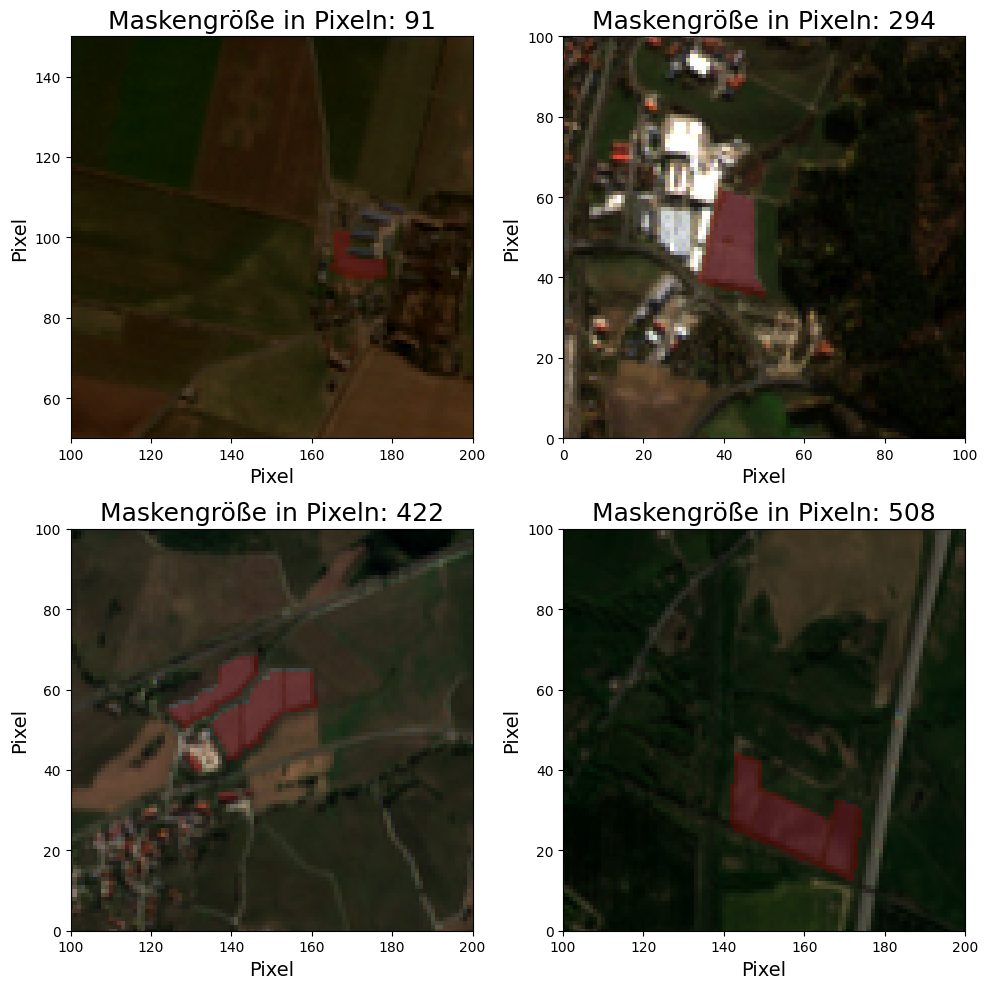

In [352]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
ax1, ax2, ax3, ax4 = axes.flatten()

ax1.imshow(image_small_mask);
ax1.imshow(small_mask[0, :, :], alpha=0.4*(small_mask[0, :, :] > 0), cmap='jet');
ax1.set_title(f"Maskengröße in Pixeln: {small_mask.sum()}", fontsize=18)
ax1.set_ylim(50, 150)
ax1.set_xlim(100, 200)
ax1.set_xlabel('Pixel', fontsize=14)
ax1.set_ylabel('Pixel', fontsize=14)

ax2.imshow(image_medium_mask);
ax2.imshow(medium_mask[0, :, :], alpha=0.4*(medium_mask[0, :, :] > 0), cmap='jet');
ax2.set_title(f"Maskengröße in Pixeln: {medium_mask.sum()}", fontsize=18)
ax2.set_ylim(0, 100)
ax2.set_xlim(0, 100)
ax2.set_xlabel('Pixel', fontsize=14)
ax2.set_ylabel('Pixel', fontsize=14)

ax3.imshow(image_large_mask);
ax3.imshow(large_mask[0, :, :], alpha=0.4*(large_mask[0, :, :] > 0), cmap='jet');
ax3.set_title(f"Maskengröße in Pixeln: {large_mask.sum()}", fontsize=18)
ax3.set_ylim(0, 100)
ax3.set_xlim(100, 200)
ax3.set_xlabel('Pixel', fontsize=14)
ax3.set_ylabel('Pixel', fontsize=14)

ax4.imshow(image_very_large_mask);
ax4.imshow(very_large_mask[0, :, :], alpha=0.4*(very_large_mask[0, :, :] > 0), cmap='jet');
ax4.set_title(f"Maskengröße in Pixeln: {very_large_mask.sum()}", fontsize=18)
ax4.set_ylim(0, 100)
ax4.set_xlim(100, 200)
ax4.set_xlabel('Pixel', fontsize=14)
ax4.set_ylabel('Pixel', fontsize=14)

fig.tight_layout()
plt.show()

In [345]:
fig.savefig('figures/raw_data/mask_sizes_images.pdf', bbox_inches='tight')

#### Average brightness of image patches

In [44]:
avg_image_brightness_list = []
file_paths_list = []
images_prepro_path = Path(r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\images_undersampling')
for file_path in images_prepro_path.glob('*.tif'):
    image = rasterio.open(file_path).read()
    avg_image_brightness_list.append(image.mean())
    file_paths_list.append(file_path)

In [45]:
df = pd.DataFrame({'avg_brightness': avg_image_brightness_list, 'file_path': file_paths_list})

In [33]:
mean_avg_brightness = np.mean(avg_image_brightness_list)
median_avg_brightness  = np.median(avg_image_brightness_list)

In [154]:
print(f"Max image brightness: {max(avg_image_brightness_list):.3f}")
print(f"Min image brightness: {min(avg_image_brightness_list):.3f}")
print(f"Mean image brightness: {mean_avg_brightness:.3f}")
print(f"Median image brightness: {median_avg_brightness:.3f}")

Max image brightness: 0.652
Min image brightness: 0.011
Mean image brightness: 0.246
Median image brightness: 0.233


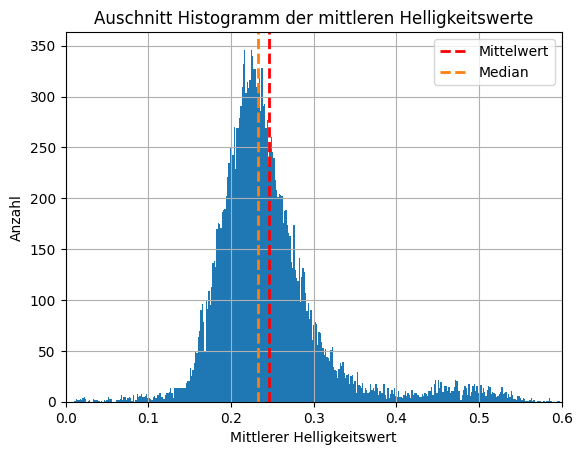

In [35]:
plt.hist(avg_image_brightness_list, bins=400)
plt.grid(True)
plt.xlim(0, 0.60)
plt.xlabel('Mittlerer Helligkeitswert')
plt.ylabel('Anzahl')
plt.title('Auschnitt Histogramm der mittleren Helligkeitswerte')
plt.axvline(mean_value, color='r', linestyle='dashed', linewidth=2)
plt.axvline(median_value, color='tab:orange', linestyle='dashed', linewidth=2)
plt.legend(['Mittelwert', 'Median'])
plt.show()

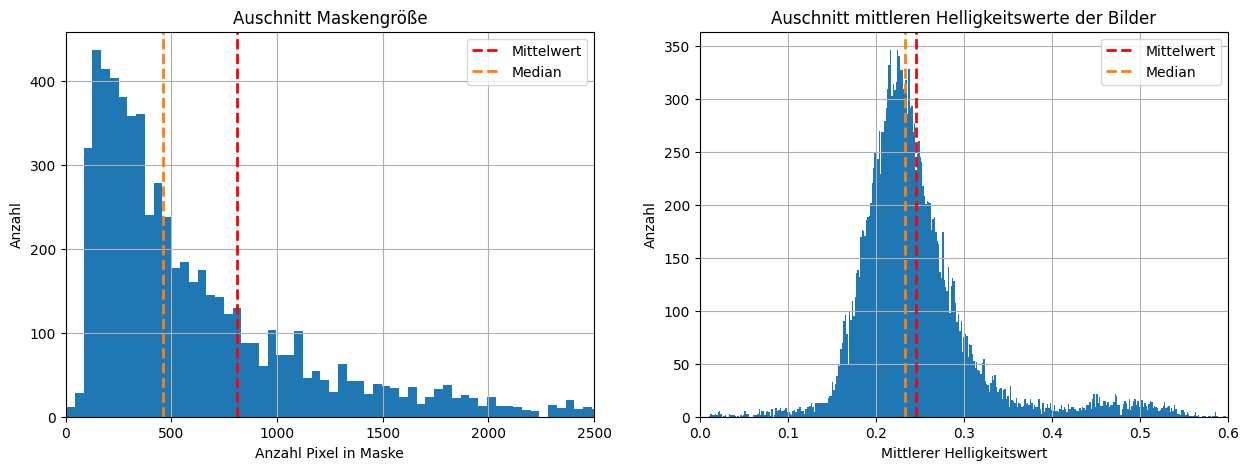

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.hist(mask_size_list, bins=500)
ax1.grid(True)
ax1.set_xlim(0, 2500)
ax1.set_xlabel('Anzahl Pixel in Maske')
ax1.set_ylabel('Anzahl')
ax1.set_title(f'Auschnitt Maskengröße')
ax1.axvline(mean_mask_size, color='r', linestyle='dashed', linewidth=2)
ax1.axvline(median_mask_size, color='tab:orange', linestyle='dashed', linewidth=2)
ax1.legend(['Mittelwert', 'Median'])

ax2.hist(avg_image_brightness_list, bins=400)
ax2.grid(True)
ax2.set_xlim(0, 0.60)
ax2.set_xlabel('Mittlerer Helligkeitswert')
ax2.set_ylabel('Anzahl')
ax2.set_title('Auschnitt mittleren Helligkeitswerte der Bilder')
ax2.axvline(mean_avg_brightness, color='r', linestyle='dashed', linewidth=2)
ax2.axvline(median_avg_brightness, color='tab:orange', linestyle='dashed', linewidth=2)
ax2.legend(['Mittelwert', 'Median'])
plt.show()

In [43]:
fig.savefig('figures/raw_data/histogram_mask_size_brightness.pdf', bbox_inches='tight')

In [50]:
df.sort_values(by=['avg_brightness'], inplace=True)

In [51]:
df.head()

,avg_brightness,file_path
17567,0.010605,C:\Users\Fabian\Documents\Github_Masterthesis\...
3968,0.012400,C:\Users\Fabian\Documents\Github_Masterthesis\...
10805,0.012461,C:\Users\Fabian\Documents\Github_Masterthesis\...
16132,0.012822,C:\Users\Fabian\Documents\Github_Masterthesis\...
16346,0.014125,C:\Users\Fabian\Documents\Github_Masterthesis\...


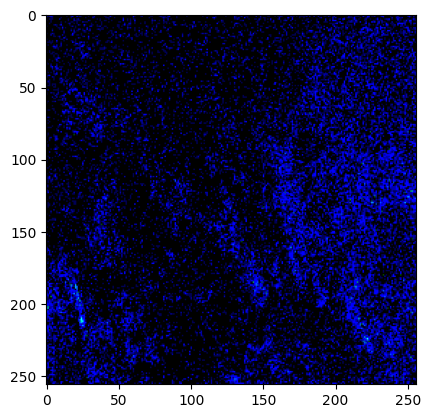

In [132]:
data = df.iloc[50, 1]
image = rasterio.open(data).read()[1:4, :, :].transpose(1, 2, 0)
plt.imshow(image);

In [148]:
image_with_high_reflectance = rasterio.open(df.iloc[80, 1]).read()[1:4].transpose(1, 2, 0)
avg_brightness_high_reflectance = df.iloc[80, 0]
image_with_high_cutoff = rasterio.open(df.iloc[45, 1]).read()[1:4].transpose(1, 2, 0)
avg_brightness_high_cutoff = df.iloc[45, 0]
image_with_water_distortion = rasterio.open(df.iloc[50, 1]).read()[1:4].transpose(1, 2, 0)
avg_brightness_water_distortion = df.iloc[50, 0]

(-0.5, 255.5, 255.5, -0.5)

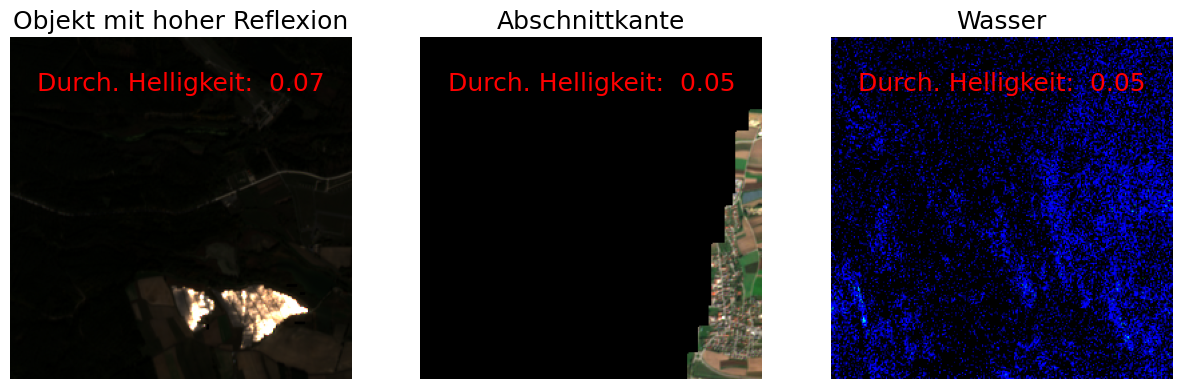

In [164]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.imshow(image_with_high_reflectance)
ax1.set_title('Objekt mit hoher Reflexion', fontsize=18)
ax1.text(0.5, 0.9, f'Durch. Helligkeit: {avg_brightness_high_reflectance: .2f}', fontsize=18, horizontalalignment='center', verticalalignment='top', transform=ax1.transAxes, color='r')
ax1.axis('off')

ax2.imshow(image_with_high_cutoff)
ax2.set_title('Abschnittkante', fontsize=18)
ax2.text(0.5, 0.9, f'Durch. Helligkeit: {avg_brightness_high_cutoff: .2f}', fontsize=18, horizontalalignment='center', verticalalignment='top', transform=ax2.transAxes, color='r')
ax2.axis('off')

ax3.imshow(image_with_water_distortion)
ax3.set_title('Wasser', fontsize=18)
ax3.text(0.5, 0.9, f'Durch. Helligkeit: {avg_brightness_water_distortion: .2f}', fontsize=18, horizontalalignment='center', verticalalignment='top', transform=ax3.transAxes, color='r')
ax3.axis('off')

In [165]:
fig.savefig('figures/raw_data/low_brightness_examples.pdf', bbox_inches='tight')

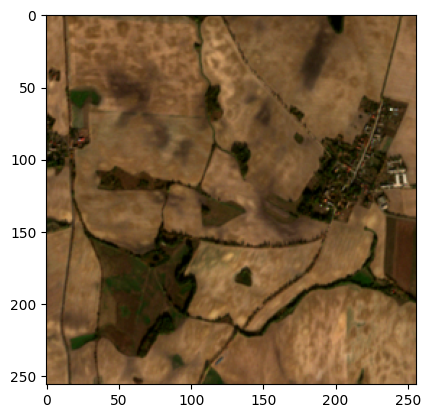

In [218]:
data = df.iloc[-950, 1]
image = rasterio.open(data).read()[1:4, :, :].transpose(1, 2, 0)
plt.imshow(image);

In [219]:
image_with_water_reflectance = rasterio.open(df.iloc[-1000, 1]).read()[1:4].transpose(1, 2, 0)
avg_brightness_water_reflectance = df.iloc[-1000, 0]
image_with_snow = rasterio.open(df.iloc[-1, 1]).read()[1:4].transpose(1, 2, 0)
avg_brightness_snow = df.iloc[-1, 0]
image_with_bright_crops = rasterio.open(df.iloc[-950, 1]).read()[1:4].transpose(1, 2, 0)
avg_brightness_bright_crops = df.iloc[-950, 0]

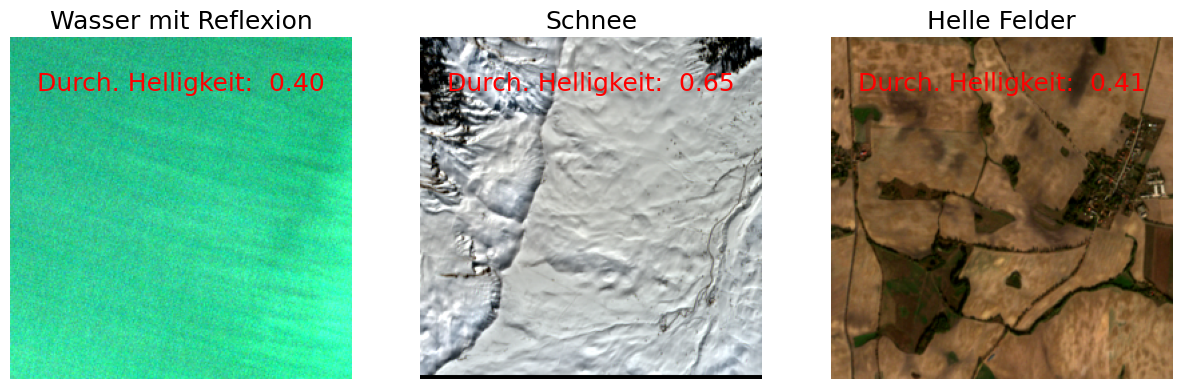

In [228]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.imshow(image_with_water_reflectance)
ax1.set_title('Wasser mit Reflexion', fontsize=18)
ax1.text(0.5, 0.9, f'Durch. Helligkeit: {avg_brightness_water_reflectance: .2f}', fontsize=18, horizontalalignment='center', verticalalignment='top', transform=ax1.transAxes, color='r')
ax1.axis('off')

ax2.imshow(image_with_snow)
ax2.set_title('Schnee', fontsize=18)
ax2.text(0.5, 0.9, f'Durch. Helligkeit: {avg_brightness_snow: .2f}', fontsize=18, horizontalalignment='center', verticalalignment='top', transform=ax2.transAxes, color='r')
ax2.axis('off')

ax3.imshow(image_with_bright_crops)
ax3.set_title('Helle Felder', fontsize=18)
ax3.text(0.5, 0.9, f'Durch. Helligkeit: {avg_brightness_bright_crops: .2f}', fontsize=18, horizontalalignment='center', verticalalignment='top', transform=ax3.transAxes, color='r')
ax3.axis('off');


In [229]:
fig.savefig('figures/raw_data/high_brightness_examples.pdf', bbox_inches='tight')

### Create trainings data (sort them in train, validation and test set) and convert them to tensors (.pt files)

In [3]:
images_prepro_path = Path(r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\images_undersampling')
masks_prepro_path = Path(r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\masks_undersampling')

In [4]:
# create a list of all tiles
tile_list = []
for file_path in images_prepro_path.glob("*.tif"):
    filename = file_path.stem
    tile, number, date = filename.split("_")
    tile_list.append(tile)

# set is used to get unique values of tiles
tiles_unique = list(set(tile_list))

In [5]:
print(f'Number of tiles: {len(tiles_unique)}')

Number of tiles: 56


In [6]:
# select random tiles for train, val and test
random.seed(42)
random.shuffle(tiles_unique)

num_total = len(tiles_unique)
num_train = int(num_total * 0.7)
num_val = int(num_total * 0.2)

In [7]:
# create train, val and test list
train_list = tiles_unique[:num_train]
val_list = tiles_unique[num_train : num_train + num_val]
test_list = tiles_unique[num_train + num_val :]

In [8]:
print("Number of tiles in each set:")
print(f'Train: {len(train_list)}')
print(f'Val: {len(val_list)}')
print(f'Test: {len(test_list)}')

Number of tiles in each set:
Train: 39
Val: 11
Test: 6


In [41]:
# create a directory for each set
data_dir = Path(r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\data_splitted_undersampling')
for set_name in ["train", "val", "test"]:
    os.makedirs(data_dir / set_name, exist_ok=True)
    os.makedirs(data_dir / set_name / "images", exist_ok=True)
    os.makedirs(data_dir / set_name / "masks", exist_ok=True)

In [42]:
num_files = len(list(images_prepro_path.glob("*.tif")))
for file in tqdm(images_prepro_path.glob("*.tif"), total=num_files):
    file_stammed = file.stem
    filename = file.name
    tile, _, _ = file_stammed.split("_")

    image_path = images_prepro_path / filename
    mask_path = masks_prepro_path / filename
    
    image = rasterio.open(image_path).read()
    mask = rasterio.open(mask_path).read()
    
    image_tensor = torch.from_numpy(image)
    mask_tensor = torch.from_numpy(mask)

    if tile in train_list:
        torch.save(image_tensor, data_dir / "train" / "images" / f"{file_stammed}.pt")
        torch.save(mask_tensor, data_dir / "train" / "masks" / f"{file_stammed}.pt")
    elif tile in val_list:
        torch.save(image_tensor, data_dir / "val" / "images" / f"{file_stammed}.pt")
        torch.save(mask_tensor, data_dir / "val" / "masks" / f"{file_stammed}.pt")
    elif tile in test_list:
        torch.save(image_tensor, data_dir / "test" / "images" / f"{file_stammed}.pt")
        torch.save(mask_tensor, data_dir / "test" / "masks" / f"{file_stammed}.pt")
    else:
        print("Error: Tile not in any set!")

  0%|          | 0/20683 [00:00<?, ?it/s]

100%|██████████| 20683/20683 [09:50<00:00, 35.03it/s]


In [47]:
# check if all files are copied
print("Number of files in each set:")
print(f'Train images: {len(list(data_dir.glob("train/images/*.pt")))}')
print(f'Train masks: {len(list(data_dir.glob("train/masks/*.pt")))}')
print(f'Val images: {len(list(data_dir.glob("val/images/*.pt")))}')
print(f'Val masks: {len(list(data_dir.glob("val/masks/*.pt")))}')
print(f'Test images: {len(list(data_dir.glob("test/images/*.pt")))}')
print(f'Test masks: {len(list(data_dir.glob("test/masks/*.pt")))}')

Number of files in each set:
Train images: 14178
Train masks: 14178
Val images: 4648
Val masks: 4648
Test images: 1857
Test masks: 1857


### Create cleaned data set

In [9]:
# create a directory for each set
data_dir = Path(r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\data_splitted_undersampling_cleaned')
for set_name in ["train", "val", "test"]:
    os.makedirs(data_dir / set_name, exist_ok=True)
    os.makedirs(data_dir / set_name / "images", exist_ok=True)
    os.makedirs(data_dir / set_name / "masks", exist_ok=True)

In [10]:
num_files = len(list(images_prepro_path.glob("*.tif")))
for file in tqdm(images_prepro_path.glob("*.tif"), total=num_files):
    file_stammed = file.stem
    filename = file.name
    tile, _, _ = file_stammed.split("_")

    image_path = images_prepro_path / filename
    mask_path = masks_prepro_path / filename
    
    image = rasterio.open(image_path).read()
    mask = rasterio.open(mask_path).read()
    
    if mask.sum() > 0 and mask.sum() <= 400:
        continue

    if image.mean() < 0.1:
        continue
       
    image_tensor = torch.from_numpy(image)
    mask_tensor = torch.from_numpy(mask)

    if tile in train_list:
        torch.save(image_tensor, data_dir / "train" / "images" / f"{file_stammed}.pt")
        torch.save(mask_tensor, data_dir / "train" / "masks" / f"{file_stammed}.pt")
    elif tile in val_list:
        torch.save(image_tensor, data_dir / "val" / "images" / f"{file_stammed}.pt")
        torch.save(mask_tensor, data_dir / "val" / "masks" / f"{file_stammed}.pt")
    elif tile in test_list:
        torch.save(image_tensor, data_dir / "test" / "images" / f"{file_stammed}.pt")
        torch.save(mask_tensor, data_dir / "test" / "masks" / f"{file_stammed}.pt")
    else:
        print("Error: Tile not in any set!")

100%|██████████| 20683/20683 [10:27<00:00, 32.96it/s]


In [11]:
# check if all files are copied
print("Number of files in each set:")
print(f'Train images: {len(list(data_dir.glob("train/images/*.pt")))}')
print(f'Train masks: {len(list(data_dir.glob("train/masks/*.pt")))}')
print(f'Val images: {len(list(data_dir.glob("val/images/*.pt")))}')
print(f'Val masks: {len(list(data_dir.glob("val/masks/*.pt")))}')
print(f'Test images: {len(list(data_dir.glob("test/images/*.pt")))}')
print(f'Test masks: {len(list(data_dir.glob("test/masks/*.pt")))}')

Number of files in each set:
Train images: 12192
Train masks: 12192
Val images: 3482
Val masks: 3482
Test images: 1999
Test masks: 1999


### Create geojson file 

In [3]:
import geopandas as gpd
import rasterio.features
import numpy as np
from typing import Tuple, List
from shapely.geometry import Polygon
from rasterio.warp import transform_geom
from datetime import datetime


In [4]:
# strucutre of geojson
gdf = gpd.read_file(r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\geojsons\solar-parks.geojson')
gdf.head()

,avg_confidence,comment,date_of_data,first_detection,is_valid,last_detection,name_in_aws,name_of_model,peak_power,size_in_sq_m,geometry
0,0.0,None,2023-05-09,2023-05-09,non-valid,2023-05-09,32UPC_20_2023-5-9.tif,solar-park-detection,3.088,19300.0,"POLYGON ((11.20714 52.31969, 11.20787 52.31968..."
1,0.0,None,2023-05-09,2023-05-09,non-valid,2023-05-09,32UPC_20_2023-5-9.tif,solar-park-detection,4.512,28200.0,"POLYGON ((11.20472 52.31821, 11.20530 52.31820..."
2,0.0,None,2023-05-09,2023-05-09,valid,2023-05-09,32UPC_31_2023-5-9.tif,solar-park-detection,2.384,14900.0,"POLYGON ((11.61811 52.32361, 11.61870 52.32360..."
3,0.0,None,2023-05-09,2023-05-09,valid,2023-05-09,32UPC_33_2023-5-9.tif,solar-park-detection,4.672,29200.0,"POLYGON ((11.68509 52.30520, 11.68568 52.30519..."
4,0.0,None,2023-05-09,2023-05-09,non-valid,2023-05-09,32UPC_193_2023-5-9.tif,solar-park-detection,1.408,8800.0,"POLYGON ((11.09063 52.23873, 11.09060 52.23810..."


In [19]:
data_dir = Path(r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\data_splitted_undersampling')
mask_dir = Path(r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\masks_undersampling')
file_list = data_dir.glob("test/masks/*.pt")

In [75]:
def masks_to_polygons(
    masks: np.ndarray, metadata: dict
) -> Tuple[List[Polygon], List[float]]:
    masks = masks.astype(np.uint8)
    transform = metadata["transform"]
    crs = metadata["crs"]
    # extract shapes
    shapes = rasterio.features.shapes(masks, transform=transform)
    polygons = []
    areas = []
    peak_powers = []
    for shape in shapes:
        if shape[1] == 1:
            polygon = Polygon(shape[0]["coordinates"][0])
            area = polygon.area
            # realistically, the smallest solar park should be bigger than 10.000 m²
            if area >= 0:
                # Transform the polygon coordinates to EPSG:4326
                transformed_geom = transform_geom(
                    crs, "EPSG:4326", polygon.__geo_interface__
                )
                transformed_coords = transformed_geom["coordinates"][0]
                transformed_polygon = Polygon(transformed_coords)
                peak_power = calc_peak_power(area_in_sq_m=area)
                polygons.append(transformed_polygon)
                areas.append(area)
                peak_powers.append(peak_power)
    return polygons, areas, peak_powers

In [72]:
def calc_peak_power(area_in_sq_m: float) -> float:
    # https://www.bundesnetzagentur.de/SharedDocs/Downloads/DE/Sachgebiete/Energie/Unternehmen_Institutionen/ErneuerbareEnergien/PV-Freiflaechenanlagen/Bericht_Flaecheninanspruchnahme_2016.pdf?__blob=publicationFile&v=2#:~:text=Die%20bereits%20im%20Rahmen%20der,Ackerland%20in%20benachteiligten%20Gebieten%20errichtet. # noqa
    # page 8 on the pdf (german)
    # 1,6 acre = 1 MWp
    # area in sq m / 10000 = area in acr * 1.6 = peak power in MWp
    return area_in_sq_m / 10000 * 1.6

In [90]:
polygons_list = []
areas_list = []
peak_powers_list = []
filenames_list = []
for file_path in file_list:
    filename = file_path.stem
    mask = rasterio.open(mask_dir / f"{filename}.tif").read()
    metadata   = rasterio.open(mask_dir / f"{filename}.tif").meta
    if mask.sum() > 0:
        polygons, areas, peak_powers = masks_to_polygons(mask, metadata)
        polygons_list.extend(polygons)
        areas_list.extend(areas)
        peak_powers_list.extend(peak_powers)
        for i in range(len(polygons)):
            filenames_list.append(f"{filename}.tif")

In [77]:
gdf.columns

Index(['avg_confidence', 'comment', 'date_of_data', 'first_detection',
       'is_valid', 'last_detection', 'name_in_aws', 'name_of_model',
       'peak_power', 'size_in_sq_m', 'geometry'],
      dtype='object')

In [97]:
date_string = "2018-01-01"
date_obj = datetime.strptime(date_string, "%Y-%m-%d").date()
data = {
    "name_of_model": "test",
    "size_in_sq_m": areas_list,
    "peak_power": peak_powers_list,
    "date_of_data": '2018-01-01',
    "first_detection": '2018-01-01',  # will be handled on api level
    "last_detection": '2018-01-01',  # will be handled on api level
    "avg_confidence": 0,
    "name_in_aws": filenames_list,
    "is_valid": "None",
    "comment": "test",
    "geometry": polygons_list
}
df = gpd.GeoDataFrame(data)

In [98]:
df

,name_of_model,size_in_sq_m,peak_power,date_of_data,first_detection,last_detection,avg_confidence,name_in_aws,is_valid,comment,geometry
0,test,29200.0,4.672,2018-01-01,2018-01-01,2018-01-01,0,32UMA_1034_2018-11-16.tif,None,test,"POLYGON ((8.38072 50.02334, 8.38617 50.02337, ..."
1,test,29200.0,4.672,2018-01-01,2018-01-01,2018-01-01,0,32UMA_1034_2018-4-20.tif,None,test,"POLYGON ((8.38072 50.02334, 8.38617 50.02337, ..."
2,test,29200.0,4.672,2018-01-01,2018-01-01,2018-01-01,0,32UMA_1034_2018-9-27.tif,None,test,"POLYGON ((8.38072 50.02334, 8.38617 50.02337, ..."
3,test,38700.0,6.192,2018-01-01,2018-01-01,2018-01-01,0,32UMA_1042_2018-11-16.tif,None,test,"POLYGON ((8.64275 50.02427, 8.64303 50.02427, ..."
4,test,97900.0,15.664,2018-01-01,2018-01-01,2018-01-01,0,32UMA_1042_2018-11-16.tif,None,test,"POLYGON ((8.63968 50.02444, 8.64163 50.02444, ..."
...,...,...,...,...,...,...,...,...,...,...,...
625,test,41600.0,6.656,2018-01-01,2018-01-01,2018-01-01,0,32UPF_1622_2018-4-20.tif,None,test,"POLYGON ((12.01673 54.17422, 12.01780 54.17419..."
626,test,41600.0,6.656,2018-01-01,2018-01-01,2018-01-01,0,32UPF_1622_2018-7-6.tif,None,test,"POLYGON ((12.01673 54.17422, 12.01780 54.17419..."
627,test,83400.0,13.344,2018-01-01,2018-01-01,2018-01-01,0,32UPF_1623_2018-10-14.tif,None,test,"POLYGON ((12.01887 54.17417, 12.01869 54.17165..."
628,test,83400.0,13.344,2018-01-01,2018-01-01,2018-01-01,0,32UPF_1623_2018-4-20.tif,None,test,"POLYGON ((12.01887 54.17417, 12.01869 54.17165..."


In [99]:
df = df.set_geometry('geometry')

df.to_file('testset.geojson', driver='GeoJSON')

### Create cleaned dataset

In [4]:
df = gpd.read_file('solar-parks_classified.geojson')

In [5]:
df.head()

,avg_confidence,comment,date_of_data,first_detection,is_valid,last_detection,name_in_aws,name_of_model,peak_power,size_in_sq_m,geometry
0,0.0,test,2018-01-01,2018-01-01,unsure,2018-01-01,32UMA_1034_2018-4-20.tif,test,4.672,29200.0,"POLYGON ((8.38072 50.02334, 8.38617 50.02337, ..."
1,0.0,test,2018-01-01,2018-01-01,unsure,2018-01-01,32UMA_1034_2018-9-27.tif,test,4.672,29200.0,"POLYGON ((8.38072 50.02334, 8.38617 50.02337, ..."
2,0.0,test,2018-01-01,2018-01-01,unsure,2018-01-01,32UMA_1042_2018-11-16.tif,test,15.664,97900.0,"POLYGON ((8.63968 50.02444, 8.64163 50.02444, ..."
3,0.0,test,2018-01-01,2018-01-01,unsure,2018-01-01,32UMA_1042_2018-4-20.tif,test,15.664,97900.0,"POLYGON ((8.63968 50.02444, 8.64163 50.02444, ..."
4,0.0,test,2018-01-01,2018-01-01,valid,2018-01-01,32UMA_1187_2018-9-27.tif,test,2.720,17000.0,"POLYGON ((9.10467 49.94481, 9.10481 49.94481, ..."
